# Converting sklearn trees to ete3 trees.


In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets

Load some test data and train a model

In [2]:
data = datasets.load_iris()

In [3]:
X = data.data
y = data.target

In [4]:
X.shape, y.shape

((150, 4), (150,))

In [5]:
clf = DecisionTreeClassifier(random_state=1)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

### sktree_to_ete()
Function that converts sklearn tree to [ete3](http://etetoolkit.org/) tree

In [6]:
from ete3 import Tree, TreeStyle, faces, AttrFace, Face, TextFace, ImgFace

def sktree_to_ete(tree, i_format='.2e'):
    """Generates ete3 tree from sklearn Tree estimator. Extracts features, 
    thresholds, samples, impurity, and importances for each split (node). 
    Node names are sequential as extracted from sklearn tree.
    
    To show everything use:
    >>> print clf_t.get_ascii(attributes=['name', 'feature', 'tresholds', 'samples', 
                            'importance', 'impurity', 'value'], show_internal=True)
    
    Parameters
    ----------
    tree : sklearn.tree._tree.Tree
        Sklearn tree (clf.tree_ in case of DecisionTreeClassifier)
    i_format : str
        How to format feature importances. Defaults to e notation with two 
        decimals '.2e'. You might prefer float with 3 decimals '.4f', etc..
    
    Returns
    -------
    ete3.coretype.tree.TreeNode    
    """
    
    # Extract nodes    
    nodes = dict(zip(range(tree.node_count), 
        zip(tree.children_left, tree.children_right)))
    
    # Extract features and thresholds
    features = dict(zip(range(tree.node_count), tree.feature))
    thresholds = dict(zip(range(tree.node_count), tree.threshold))
    samples = dict(zip(range(tree.node_count), tree.n_node_samples))
    impurity = dict(zip(range(tree.node_count), tree.impurity))
    values = dict(zip(range(tree.node_count), [str(x) for x in tree.value]))
    importances = dict(zip([x for x in tree.feature if x != -2],
                           [format(x, i_format) for x in tree.compute_feature_importances(
                            )[np.array([x for x in tree.feature if x != -2])]]))    
    importance = dict(zip(range(tree.node_count), 
                          [importances[x] if x != -2 else 0 for x in tree.feature ]))

    #  Get all parents    
    parents = {}
    for x in nodes:
        for y in nodes:
            if x in list(nodes[y][0:2]):
                parents[x] = y
    
    # Create the tree
    for n in nodes:
        if n == 0: # root node
            t = Tree(name=n, format=2)
            for x in nodes[n][0:1]:
                if x != -1:
                    t.add_child(name=x)
        else:
            if len(t.get_leaves_by_name(n)) > 0: # node exists
                for x in nodes[n][0:1]:
                    if x != -1:
                        for y in t.search_nodes(name=n):
                            y.add_child(name=x)
                        #y[0].add_child(name=x)
            else: # node doesn't exist; find parent and create new node
                par = t.search_nodes(name=parents[n])[0]
                par.add_child(name=n)
                
    # Map atributes to nodes
    for node in t.iter_search_nodes():
        node.add_features(feature=features.get(node.name, 'none'), 
                    threshold=thresholds.get(node.name, 'none'),
                    samples=samples.get(node.name, 'none'),
                    impurity=impurity.get(node.name, 'none'),
                    value=values.get(node.name, 'none'),
                    importance=importance.get(node.name, 'none'),)           
    return t

Convert sklearn tree to ete3 tree

In [7]:
clf_t = sktree_to_ete(clf.tree_, i_format='.2f')

Check ete3 tree features

In [8]:
clf_t.features

{'dist',
 'feature',
 'importance',
 'impurity',
 'name',
 'samples',
 'support',
 'threshold',
 'value'}

Print the tree

In [9]:
print(clf_t.get_ascii(attributes=['feature', 'samples', 'importance'], show_internal=True))


            /--2, 50, 0
           |
           |                                  /--2, 47, 0
           |                       /3, 48, 0.92
-3, 150, 0.92                     |           \--2, 1, 0
           |            /2, 54, 0.05
           |           |          |          /--2, 3, 0
           |           |           \3, 6, 0.92
           |           |                    |          /--2, 2, 0
            \3, 100, 0.92                    \0, 3, 0.03
                       |                               \--2, 1, 0
                       |
                       |                     /--2, 1, 0
                       |           /0, 3, 0.03
                        \2, 46, 0.05         \--2, 2, 0
                                  |
                                   \--2, 43, 0


Helper function for layout of grapical tree representation

In [10]:
def _layout(node):
    name_face = AttrFace("name")
    s_face = AttrFace("samples")
    v_face = AttrFace("value")
    if node.is_leaf():
        f_face = TextFace("-")
        i_face = TextFace("-")
    else:
        f_face = AttrFace("feature")
        i_face = AttrFace("importance")
    
    faces.add_face_to_node(TextFace("name"), node, column=0, position="branch-right")
    faces.add_face_to_node(TextFace("feature"), node, column=0, position="branch-right")
    faces.add_face_to_node(TextFace("samples"), node, column=0, position="branch-right")
    faces.add_face_to_node(TextFace("importance"), node, column=0, position="branch-right")
    faces.add_face_to_node(TextFace("value"), node, column=0, position="branch-right")
    faces.add_face_to_node(name_face, node, column=1, position="branch-right")
    faces.add_face_to_node(f_face, node, column=1, position="branch-right")
    faces.add_face_to_node(s_face, node, column=1, position="branch-right")
    faces.add_face_to_node(i_face, node, column=1, position="branch-right")
    faces.add_face_to_node(v_face, node, column=1, position="branch-right")

Define style

In [11]:
ts = TreeStyle()
ts.show_leaf_name = False
ts.show_scale = False
ts.layout_fn = _layout

Render the tree

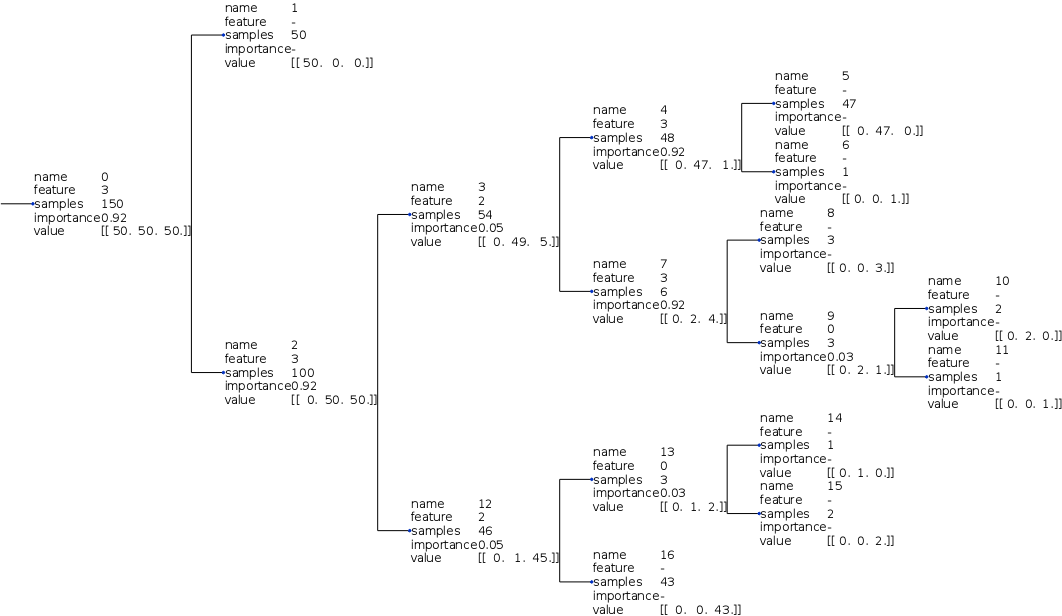

In [12]:
clf_t.render(file_name='%%inline',  w=300, units="mm", tree_style=ts)

Default graphviz rendering in scikit learn

In [13]:
from sklearn import tree
tree.export_graphviz(clf, out_file='tree.dot')   

In [14]:
!dot -Tpng tree.dot -o tree.png 

![graphviz tree](tree.png)

Copyright (C) 2016 by Samo Turk, BioMed X Innovation Center